In [1]:
import pandas as pd
import os
import numpy as np
from collections import Counter
from string import printable
from string import punctuation
import unicodedata

from gensim import corpora, models, similarities                  # LDA model
from gensim.similarities import MatrixSimilarity

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.util import ngrams

from fuzzywuzzy import fuzz

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer       # TF-IDF Vectorizer for LSA model
from sklearn.decomposition import TruncatedSVD                    # Singular Value Decomposition for LSA model

import matplotlib.pyplot as plt
import seaborn as sns



C:\Users\brindhasrikrishna\Anaconda2\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def data_preprocessing(df, col_name, output_col_name_1, output_col_name_2):
    st= set(printable)
    df[output_col_name_1] = df[col_name].str.lower()
    df[output_col_name_1] = df[output_col_name_1].str.strip(punctuation)
    df[output_col_name_1] = df[output_col_name_1].str.replace(r"[\"\'\,!]", '')
    df[output_col_name_1] = df[output_col_name_1].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")
    df[output_col_name_1] = df[output_col_name_1].str.replace("\r\n\r\n", '')
    df[output_col_name_1] = df[output_col_name_1].str.replace("\r\n", '')
    df[output_col_name_1] = df[output_col_name_1].astype(str).fillna('No location')
    df[output_col_name_1] = df[output_col_name_1].apply(lambda x: ''.join([" " if i not in st else i for i in x]))
    df[output_col_name_1] = df[output_col_name_1].str.encode('ascii', 'ignore').str.decode('ascii')
    df[output_col_name_2] = df[output_col_name_1].str.findall('\w{4,}').str.join(' ')
    
    return(df)

In [3]:
def create_tokens_stem_lem_bigrams(df, col_name, output_col_name_1, output_col_name_2):
    porter = nltk.stem.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(['corona', 'virus', 'sarscov2', 'coronavirususa', 'hcov19', 'covid19'])
    df[output_col_name_1] = df[col_name].apply(word_tokenize)
    df[output_col_name_1] = df[output_col_name_1].apply(lambda x: [w for w in x if w not in stop_words ])
    df[output_col_name_1] = df[output_col_name_1].apply(lambda x: [porter.stem(w) for w in x])
    df[output_col_name_1] = df[output_col_name_1].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    df[output_col_name_2] = df[output_col_name_1].apply(lambda x: list(ngrams(x,2)))
    
    return(df)

In [4]:
def create_bigram_frequency(bigrams_list):
    bigrams_dict = {}
    for bigrams in bigrams_list:
        for bigram in bigrams:
            bigrams_dict[bigram] = bigrams_dict.get(bigram, 0) + 1
    bigrams_freq = []
    for key, value in bigrams_dict.items():
        bigrams_freq.append((value, key))
    
    return(bigrams_freq)

In [5]:
def create_location_frequency(location_list):
    location_dict = {}
    for location in location_list:
        location_dict[location] = location_dict.get(location, 0) + 1
    location_freq = []
    for key, value in location_dict.items():
        location_freq.append((value, key))
    
    return(location_freq)

In [6]:
def count_occurrence_of_words(df, input_col, output_col_1, output_col_2, pattern):
    df[output_col_1] = [','.join(map(str,l)) for l in df[input_col]]
    df[output_col_2] = df[output_col_1].str.contains(pattern)
    
    return(df)

In [7]:
def standardize_location(df, df_loc, data_location_col, loc_master_state_col, loc_master_city_col,\
                         loc_master_country_col, output_state_col, \
                         output_country_col):
    loc_state = []
    loc_country=[]
    for i in df.index:
        max_ratio=0
        max_ratio_state=''
        max_ratio_country=''
        for j in df_loc.index:
            fr_state = fuzz.ratio(df.loc[i, data_location_col], df_loc.loc[j, loc_master_state_col])
            if fr_state > max_ratio:
                max_ratio = fr_state
                max_ratio_state = df_loc.loc[j, loc_master_state_col]
                max_ratio_country=df_loc.loc[j, loc_master_country_col]

            fr_city = fuzz.ratio(df.loc[i, data_location_col], df_loc.loc[j,loc_master_city_col])
            if fr_city>max_ratio:
                max_ratio = fr_city
                max_ratio_state = df_loc.loc[j, loc_master_state_col]
                max_ratio_country=df_loc.loc[j, loc_master_country_col]
        
        loc_state.append(max_ratio_state)
        loc_country.append(max_ratio_country)
    
    df[output_state_col] = loc_state
    df[output_country_col] = loc_country

    return(df)

In [8]:
os.chdir('B:\\Travel\\US\\USF_Course\\TextAnalytics\\TextAnalyticsProject\\CoronavirusReasonsForRetweet\\')

In [9]:
df_a = pd.read_csv('tweets_28_3_2020_16_25.csv')
df_b = pd.read_csv('tweets_29_3_2020_16_59.csv')
df_c = pd.read_csv('tweets_29_3_2020_17_3.csv')
df_d = pd.read_csv('tweets_30_3_2020_21_35.csv')
df_e = pd.read_csv('tweets_30_3_2020_22_9.csv')
df_f= pd.read_csv('tweets_30_3_2020_22_35.csv')
df_g=pd.read_csv('tweets_5_4_2020_13_42.csv')
df_h=pd.read_csv('tweets_9_4_2020_15_22.csv')
df_i=pd.read_csv('tweets_14_4_2020_21_57.csv')
df_j=pd.read_csv('tweets_19_4_2020_0_16.csv')
df_k=pd.read_csv('tweets_22_4_2020_15_27.csv')

In [10]:
df = df_a.append([df_b, df_c, df_d, df_e, df_f, df_g, df_h, df_i, df_j, df_k])

In [11]:
df = df.fillna('blank')

In [12]:
df=df.reset_index()

In [13]:
col_name = 'full_text'
output_col_name_1 = 'cleaned_text'
output_col_name_2 = 'cleaned_text_no_hashtag'
df = data_preprocessing(df, col_name, output_col_name_1,output_col_name_2 )

In [14]:
col_name = 'cleaned_text_no_hashtag'
output_col_name_1 = 'tokens'
output_col_name_2 = 'tokens_bigrams'
df = create_tokens_stem_lem_bigrams(df, col_name, output_col_name_1, output_col_name_2)

In [15]:
df.loc[1, 'cleaned_text_no_hashtag']

u'this really gross shouldnt surpriseddemocrats have been pushing conspiracy theories with abandon over years barbara boxer baselessly accuses president trump covering wuhanvirus pushback from'

In [16]:
bigrams_freq = create_bigram_frequency(df['tokens_bigrams'])

In [17]:
bigrams_freq.sort(reverse=True)
top25_bigrams = bigrams_freq[0:25]
values, bigrams = zip(*top25_bigrams)
bigrams_joined = [w[0]+"-"+w[1] for w in bigrams]

In [18]:
df.shape

(15829, 16)

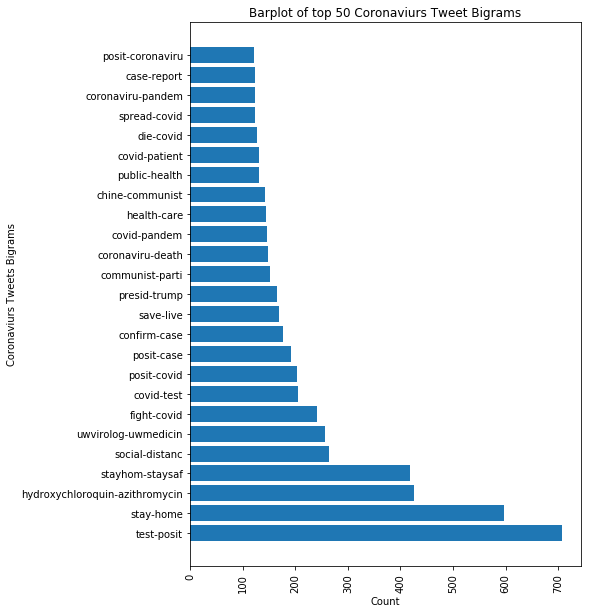

In [19]:
fig = plt.figure(figsize=(7,10))
plt.barh(bigrams_joined, values)
plt.ylabel('Coronaviurs Tweets Bigrams')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Barplot of top 50 Coronaviurs Tweet Bigrams')
plt.show()

Predict the locations with highest incidents of coronavirus

In [20]:
col_name = 'location'
output_col_name_1 = 'cleaned_location'
output_col_name_2 = 'cleaned_location_1'
df = data_preprocessing(df, col_name, output_col_name_1, output_col_name_2)
df['cleaned_location'] = df['cleaned_location'].str.replace('                        ', 'blank')
#df['cleaned_location'] = df['cleaned_location'].replace(regex=['^.*india.*$'], value='bharath')
df['cleaned_location'] = df['cleaned_location'].replace(regex=['^.*az.*$'], value='arizona')

df['created_at_datetime'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')
df['created_at_date'] = df['created_at_datetime'].dt.date


In [21]:
col_name = 'cleaned_location'
output_col_name_1 = 'tokens_location'
output_col_name_2 = 'tokens_location_bigram'
df = create_tokens_stem_lem_bigrams(df, col_name, output_col_name_1, output_col_name_2)

In [22]:
df = df.drop(['index', 'Unnamed: 0'], axis=1)

In [23]:
bigrams_freq_location = create_bigram_frequency(df['tokens_location_bigram'])

In [24]:
bigrams_freq_location.sort(reverse=True)
top25_bigrams_location = bigrams_freq_location[0:25]
values_location, bigrams_location = zip(*top25_bigrams_location)
bigrams_joined_location = [w[0]+"-"+w[1] for w in bigrams_location]

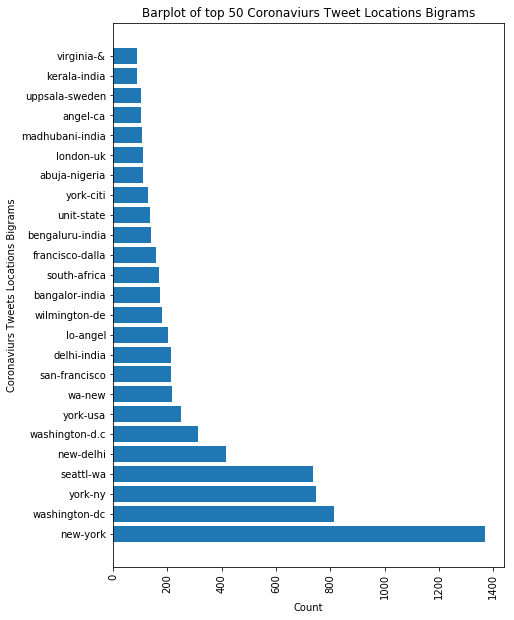

In [25]:
fig = plt.figure(figsize=(7,10))
plt.barh(bigrams_joined_location, values_location)
plt.ylabel('Coronaviurs Tweets Locations Bigrams')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Barplot of top 50 Coronaviurs Tweet Locations Bigrams')
plt.show()

In [26]:
bigrams = [('test', 'posit'), ('confirm', 'case'), ('uwmedicin', 'posit'), \
          ('covid', 'patient'), ('posit', 'case'), ('posit', 'covid'), ('coronaviru', 'case')]

#words = ['test', 'posit', 'case']
words = ['test', 'posit', 'confirm', 'case', 'uwmedicin', 'posit', 'covid', 'patient',\
            'posit', 'case', 'posit', 'covid', 'coronaviru', 'case']
pattern = '|'.join(words)
input_col = 'tokens'
output_col_1 = 'token_string'
output_col_2 = 'test_positive_y_n'
df = count_occurrence_of_words(df, input_col, output_col_1, output_col_2, pattern)

In [27]:
df_tmp = df[df['test_positive_y_n']==True]

In [28]:
bigrams_freq_location_positive = create_bigram_frequency(df_tmp['tokens_location_bigram'])

In [29]:
bigrams_freq_location_positive.sort(reverse=True)
top25_bigrams_location_positive = bigrams_freq_location_positive[0:25]
values_location_positive, bigrams_location_positive = zip(*top25_bigrams_location_positive)
bigrams_joined_location_positive = [w[0]+"-"+w[1] for w in bigrams_location_positive]

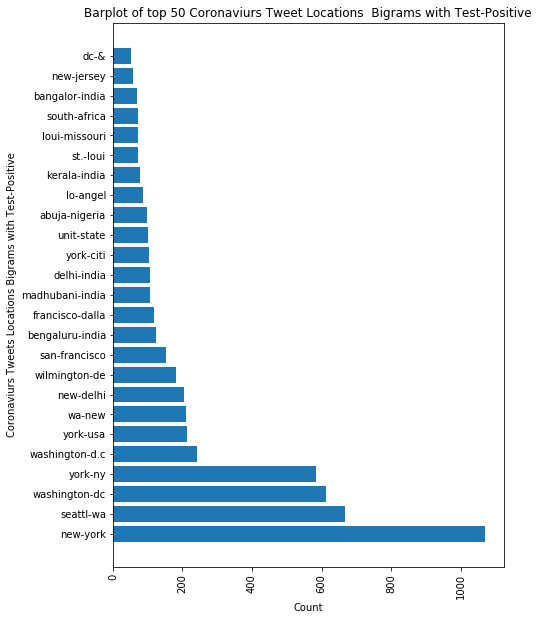

In [30]:
fig = plt.figure(figsize=(7,10))
plt.barh(bigrams_joined_location_positive, values_location_positive)
plt.ylabel('Coronaviurs Tweets Locations Bigrams with Test-Positive')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Barplot of top 50 Coronaviurs Tweet Locations  Bigrams with Test-Positive')
plt.show()

In [31]:
df_loc = pd.read_csv('US_State_City.csv')

In [32]:
df_loc = df_loc.fillna('United States')

In [33]:
df_loc = df_loc.drop_duplicates()


In [34]:
df_loc.head()

,Country,StateAbbr,StateDesc,CityName
0,US,CT,Connecticut,Hartford
1,US,NY,New York,New York
2,US,IL,Illinois,Chicago
3,US,TX,Texas,San Antonio
4,US,TX,Texas,Austin


In [35]:
df_loc_1 = pd.read_csv('world_cities.csv')
df_loc_1.columns=['CityName', 'Country', 'StateDesc']
list_of_countries = ['India', 'South Africa', 'United Kingdom', 'Japan', 'Indonesia', 'Phillipines', \
                    'South Korea', 'Brazil', 'Mexico', 'Bangladesh', 'Egypt', 'Pakistan', \
                    'Russia', 'Thailand', 'Argentina', 'Nigeria', 'Iran', 'Turkey', 'Congo', 'France', \
                    'Vietnam', 'Colombia', 'Taiwan', 'Malaysia', 'Iraq', 'Canada', 'Chile', \
                    'Spain', 'Saudi Arabia']
list_of_cities = ['Tokyo', 'Jakarta', 'Delhi', 'Manila', 'Seoul', 'Mumbai', 'Sao Paulo', \
                  'Mexico City', 'Dhaka', 'Osaka', 'Cairo', 'Karachi', 'Moscow', 'Bangkok', \
                 'Kolkata', 'Buenos Aires', 'Lagos', 'Tehran', 'Istanbul', 'Kinshasa', 'Rio de Janeiro', \
                 'Lahore', 'Lima', 'Bangalore', 'Paris', 'London', 'Bogota', 'Chennai', \
                 'Hyderabad', 'Johannesburg', 'Hanoi', 'Onitsha', 'Kuala Lumpur', \
                 'Ahmedabad', 'Hong Kong', 'Baghdad', 'Dusseldorf', 'Toronto', \
                 'Santiago', 'Surat', 'Madrid', 'Pune', 'Riyadh']
df_loc_1 = df_loc_1.loc[df_loc_1['Country'].isin(list_of_countries)]
df_loc_1 = df_loc_1.loc[df_loc_1['CityName'].isin(list_of_cities)]
st = set(printable)
for column in df_loc_1.columns:
    df_loc_1[column] = df_loc_1[column].apply(lambda x: ''.join([" " if i not in st else i for i in x]))

In [36]:
df_loc_1.head()

,CityName,Country,StateDesc
188,Buenos Aires,Argentina,Buenos Aires F.D.
699,Dhaka,Bangladesh,Dhaka
1560,Santiago,Brazil,Rio Grande do Sul
1602,Rio de Janeiro,Brazil,Rio de Janeiro
2465,London,Canada,Ontario


In [37]:
df_list = [df_loc[['CityName', 'Country', 'StateDesc']],df_loc_1[['CityName', 'Country', 'StateDesc']]]
df_loc_master = pd.concat(df_list, ignore_index=True)

In [38]:
os.chdir('B:\Travel\US\USF_Course\TextAnalytics\TextAnalyticsProject\CoronavirusReasonsForRetweet')
df_loc_master.to_csv('location_master.csv')

In [39]:
data_location_col= 'cleaned_location'
loc_master_state_col='StateDesc'
loc_master_city_col='CityName'
loc_master_country_col='Country'
output_state_col='cleaned_location_state'
output_country_col='cleaned_location_country'

df = standardize_location(df, df_loc_master, data_location_col, loc_master_state_col, loc_master_city_col, \
                          loc_master_country_col, output_state_col, output_country_col)


In [40]:
df_tmp_1 = df[df['test_positive_y_n']==True]
df_tmp_1 = df[df['cleaned_location_country']=='US']
#df_tmp_1 = df[df['cleaned_location_state']!='Unknown']

In [41]:
location_freq_positive = create_location_frequency(df_tmp_1['cleaned_location_state'])

In [42]:
location_freq_positive.sort(reverse=True)
top25_location_positive = location_freq_positive[0:25]
values_location_positive_1, location_positive_1 = zip(*top25_location_positive)


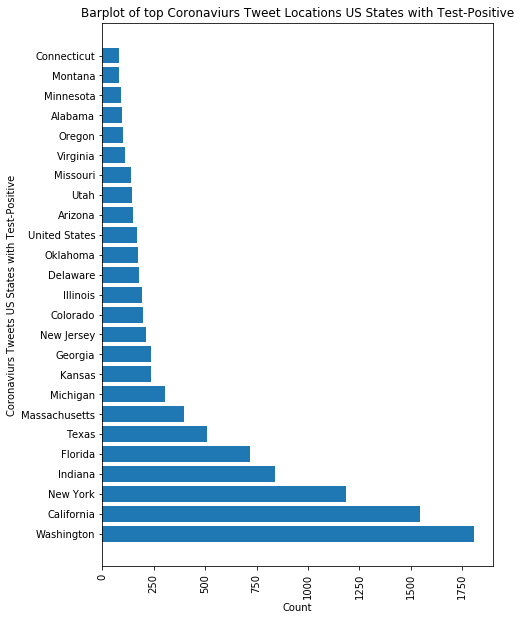

In [43]:
fig = plt.figure(figsize=(7,10))
plt.barh(location_positive_1, values_location_positive_1)
plt.ylabel('Coronaviurs Tweets US States with Test-Positive')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Barplot of top Coronaviurs Tweet Locations US States with Test-Positive')
plt.show()

In [44]:
os.chdir("B:\Travel\US\USF_Course\TextAnalytics\TextAnalyticsProject\CoronavirusReasonsForRetweet")

In [45]:
df.to_csv('coronavirus_tweets_cleaned_1.csv')



In [46]:
df_processed = pd.read_csv('coronavirus_tweets_cleaned.csv')

In [47]:
df_select = df_processed[['created_at_date','cleaned_location_country','test_positive_y_n', 'cleaned_location_state']]

In [48]:
df_select = df_select[df_select['cleaned_location_country'] == 'US']
df_select = df_select[df_select['test_positive_y_n']==True]
df_select = df_select[['cleaned_location_state', 'created_at_date', 'cleaned_location_country']]
df_select_grouped = df_select.groupby(['cleaned_location_state','created_at_date']).count().reset_index()

In [49]:
df_select_grouped.to_csv('coronavirus_tweets_cleaned_grouped.csv')

In [50]:
words = ['die', 'death']
pattern = '|'.join(words)
input_col = 'tokens'
output_col_1 = 'token_string'
output_col_2 = 'death_y_n'
df = count_occurrence_of_words(df, input_col, output_col_1, output_col_2, pattern)

Descriptive Analysis

In [51]:
df_bar = df_processed[['created_at_date', 'cleaned_location_country']]

In [52]:
df_bar_grouped=df_bar.groupby(['created_at_date']).count().reset_index()
df_bar_grouped.columns=['Tweet Date', 'Count of Tweets']

In [53]:
df_bar_grouped.head()

,Tweet Date,Count of Tweets
0,2020-03-21,299
1,2020-03-22,528
2,2020-03-23,555
3,2020-03-24,477
4,2020-03-25,297


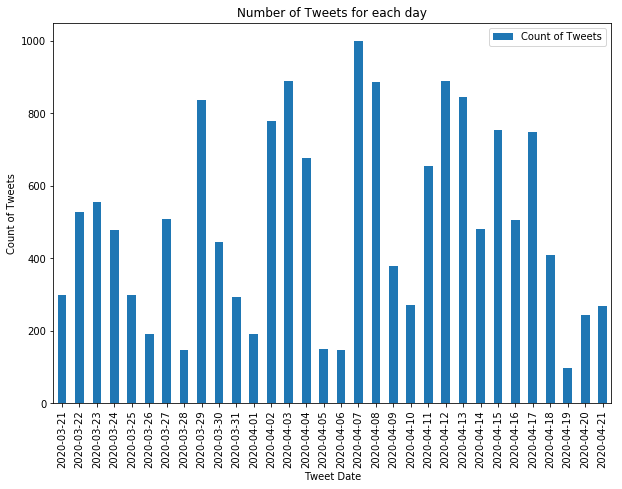

In [54]:
df_bar_grouped.plot(kind='bar', figsize=(10,7))
plt.xticks(np.arange(0,32,1), df_bar_grouped['Tweet Date'])
plt.xlabel('Tweet Date')
plt.ylabel('Count of Tweets')
plt.title('Number of Tweets for each day')
plt.show()

In [55]:
df_bar_1 = df_processed[['created_at_date', 'cleaned_location_country']]
df_bar_1 = df_bar[df_bar['cleaned_location_country']=='US']
df_bar_grouped_1=df_bar_1.groupby(['created_at_date']).count().reset_index()
df_bar_grouped_1.columns=['Tweet Date', 'Count of Tweets']


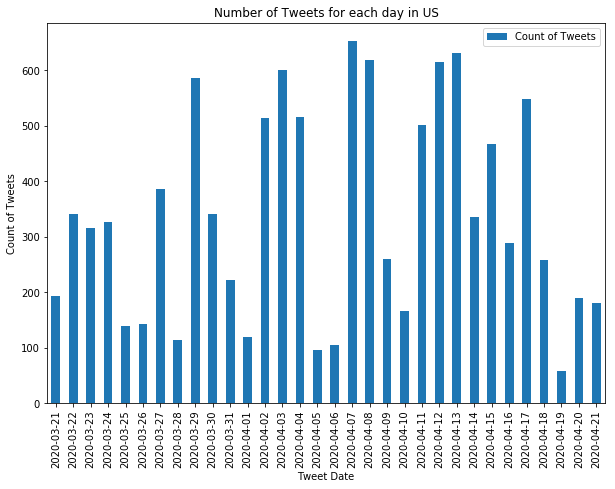

In [56]:
df_bar_grouped_1.plot(kind='bar', figsize=(10,7))
plt.xticks(np.arange(0,32,1), df_bar_grouped_1['Tweet Date'])
plt.xlabel('Tweet Date')
plt.ylabel('Count of Tweets')
plt.title('Number of Tweets for each day in US')
plt.show()

In [57]:
df_bar_2 = df_processed[df_processed['cleaned_location_country']=='US']
df_bar_2 = df_bar_2[['created_at_date', 'cleaned_location_state']]
df_bar_grouped_2 = df_bar_2.groupby('cleaned_location_state').count().reset_index()
df_bar_grouped_2.columns = ['Tweet Location', 'Count of Tweets']
df_bar_grouped_2 = df_bar_grouped_2.sort_values('Count of Tweets', ascending=False)

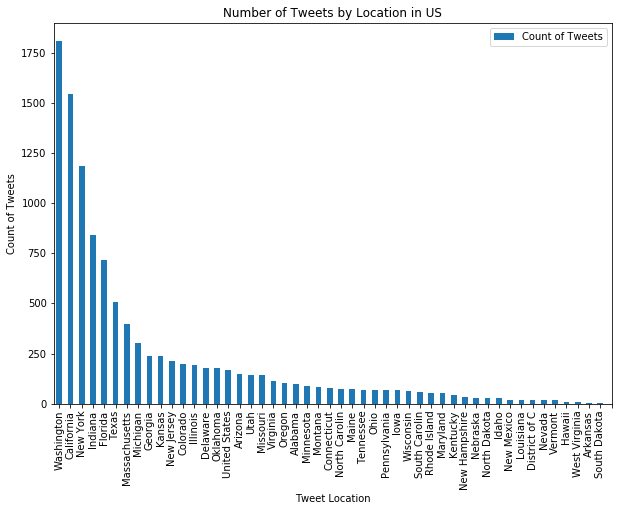

In [58]:
df_bar_grouped_2.plot(kind='bar', figsize=(10,7))
plt.xticks(np.arange(0,50,1), df_bar_grouped_2['Tweet Location'])
plt.xlabel('Tweet Location')
plt.ylabel('Count of Tweets')
plt.title('Number of Tweets by Location in US')
plt.show()

In [59]:
df_bar_grouped_2.groupby('Tweet Location').sum().sum()

Count of Tweets    10820
dtype: int64

John Hopkins

In [60]:
df_jh = pd.read_csv('john-hopkins-date-column.csv')

In [61]:
df_jh.head()

,Unnamed: 0,Province_State,Country_Region,Last_Update,Confirmed,Deaths,date
0,0,NaN,NaN,NaN,67800,3139,NaN
1,1,NaN,NaN,NaN,53578,4825,NaN
2,2,NaN,NaN,NaN,25374,1375,NaN
3,3,NaN,NaN,NaN,22213,84,NaN
4,4,NaN,NaN,NaN,20610,1556,NaN


In [62]:
df_jh = df_jh[df_jh['Country_Region']=='US']

In [63]:
df_jh.head()

,Unnamed: 0,Province_State,Country_Region,Last_Update,Confirmed,Deaths,date
304,304,New York,US,2020-03-22 23:45:00,9654,63,2020-03-22
305,305,New York,US,2020-03-22 23:45:00,1900,4,2020-03-22
306,306,New York,US,2020-03-22 23:45:00,1873,0,2020-03-22
307,307,New York,US,2020-03-22 23:45:00,1034,9,2020-03-22
308,308,New York,US,2020-03-22 23:45:00,455,1,2020-03-22


In [64]:
df_jh_grouped=df_jh[['Province_State', 'Confirmed']]
df_jh_grouped = df_jh_grouped.groupby(['Province_State']).sum().reset_index()
df_jh_grouped.columns = ['Location', 'Count of Cases']
df_jh_grouped = df_jh_grouped.sort_values('Count of Cases', ascending=False)



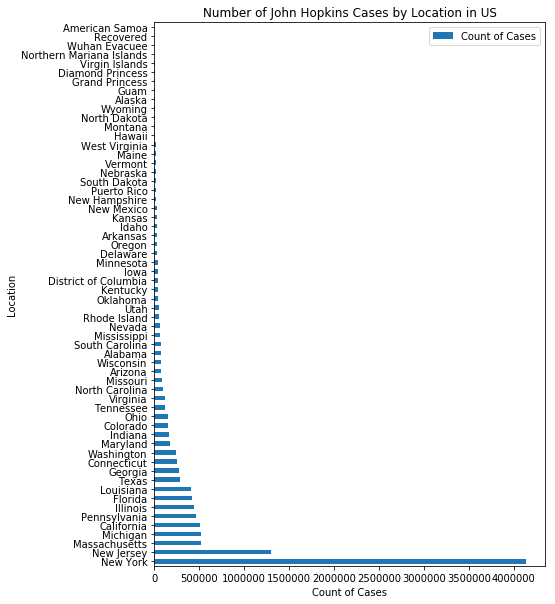

In [65]:
df_jh_grouped.plot(kind='barh', figsize=(7,10))
plt.yticks(np.arange(0,60,1), df_jh_grouped['Location'])
plt.ylabel('Location')
plt.xlabel('Count of Cases')
plt.title('Number of John Hopkins Cases by Location in US')
plt.show()

In [66]:
df_jh_ny = df_jh[df_jh['Province_State']=='New York']
df_jh_ny = df_jh_ny[['date', 'Province_State', 'Confirmed']]
df_jh_ny = df_jh_ny.groupby(['date', 'Province_State']).sum().reset_index()
df_jh_ny.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_jh_ny.head()

,created_at_date,cleaned_location_state,cases_count
0,2020-03-22,New York,15800
1,2020-03-23,New York,20884
2,2020-03-24,New York,25681
3,2020-03-25,New York,30841
4,2020-03-26,New York,37877


In [67]:


df_ny=df_processed[df_processed['cleaned_location_state']=='New York']
df_ny=df_ny[df_ny['test_positive_y_n']==True]
df_ny = df_ny[['created_at_date', 'cleaned_location_state', 'test_positive_y_n']]
df_ny_grouped = df_ny.groupby(['created_at_date','cleaned_location_state']).count().reset_index()
df_ny_grouped.columns=['created_at_date', 'cleaned_location_state', 'cases_count']

df_ny=df_processed[df_processed['cleaned_location_state']=='New York']
df_ny=df_ny[df_ny['test_positive_y_n']==True]
df_ny = df_ny[['created_at_date', 'cleaned_location_state', 'test_positive_y_n']]
df_ny_grouped = df_ny.groupby(['created_at_date','cleaned_location_state']).count().reset_index()
df_ny_grouped.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_ny_grouped.head()

df_ny_grouped.head()


,created_at_date,cleaned_location_state,cases_count
0,2020-03-21,New York,18
1,2020-03-22,New York,26
2,2020-03-23,New York,18
3,2020-03-24,New York,12
4,2020-03-25,New York,13


In [68]:
df_ny_grouped_merged = df_jh_ny.merge(df_ny_grouped, on=['created_at_date', 'cleaned_location_state'])
df_ny_grouped_merged.head()

,created_at_date,cleaned_location_state,cases_count_x,cases_count_y
0,2020-03-22,New York,15800,26
1,2020-03-23,New York,20884,18
2,2020-03-24,New York,25681,12
3,2020-03-25,New York,30841,13
4,2020-03-26,New York,37877,9


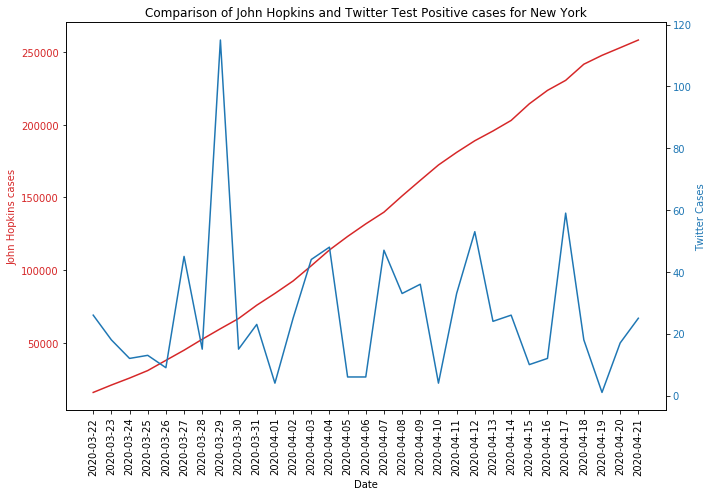

In [70]:


t = df_ny_grouped_merged['created_at_date']
data1 = df_ny_grouped_merged['cases_count_x']
data2 = df_ny_grouped_merged['cases_count_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins cases', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter Test Positive cases for New York')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter Cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


California

In [71]:
df_jh_ca = df_jh[df_jh['Province_State']=='California']
df_jh_ca = df_jh_ca[['date', 'Province_State', 'Confirmed']]
df_jh_ca = df_jh_ca.groupby(['date', 'Province_State']).sum().reset_index()
df_jh_ca.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_jh_ca.head()

,created_at_date,cleaned_location_state,cases_count
0,2020-03-22,California,1646
1,2020-03-23,California,2108
2,2020-03-24,California,2538
3,2020-03-25,California,2998
4,2020-03-26,California,3899


In [72]:


df_ca=df_processed[df_processed['cleaned_location_state']=='California']
df_ca=df_ca[df_ca['test_positive_y_n']==True]
df_ca = df_ca[['created_at_date', 'cleaned_location_state', 'test_positive_y_n']]
df_ca_grouped = df_ca.groupby(['created_at_date','cleaned_location_state']).count().reset_index()
df_ca_grouped.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_ca_grouped.head()


,created_at_date,cleaned_location_state,cases_count
0,2020-03-21,California,15
1,2020-03-22,California,16
2,2020-03-23,California,32
3,2020-03-24,California,19
4,2020-03-25,California,17


In [73]:
df_ca_grouped_merged = df_jh_ca.merge(df_ca_grouped, on=['created_at_date', 'cleaned_location_state'])
df_ca_grouped_merged.head()

,created_at_date,cleaned_location_state,cases_count_x,cases_count_y
0,2020-03-22,California,1646,16
1,2020-03-23,California,2108,32
2,2020-03-24,California,2538,19
3,2020-03-25,California,2998,17
4,2020-03-26,California,3899,6


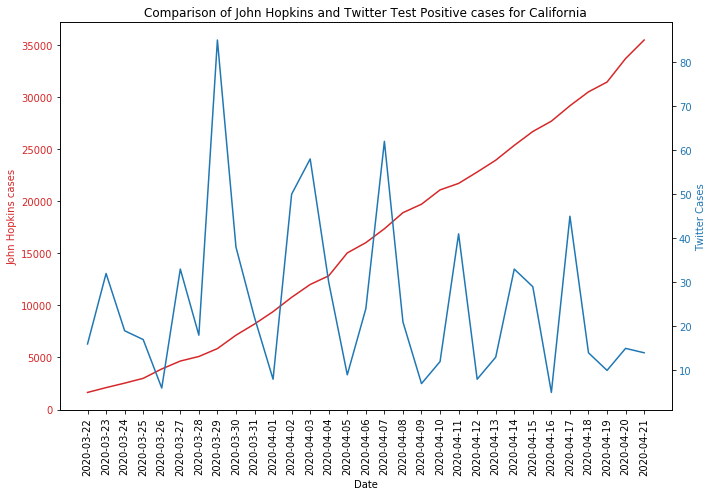

In [74]:


t = df_ca_grouped_merged['created_at_date']
data1 = df_ca_grouped_merged['cases_count_x']
data2 = df_ca_grouped_merged['cases_count_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins cases', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter Test Positive cases for California')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter Cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Washington

In [75]:
df_jh_wa = df_jh[df_jh['Province_State']=='Washington']
df_jh_wa = df_jh_wa[['date', 'Province_State', 'Confirmed']]
df_jh_wa = df_jh_wa.groupby(['date', 'Province_State']).sum().reset_index()
df_jh_wa.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_jh_wa.head()

,created_at_date,cleaned_location_state,cases_count
0,2020-03-22,Washington,1997
1,2020-03-23,Washington,2221
2,2020-03-24,Washington,2328
3,2020-03-25,Washington,2591
4,2020-03-26,Washington,3207


In [76]:


df_wa=df_processed[df_processed['cleaned_location_state']=='Washington']
df_wa=df_wa[df_wa['test_positive_y_n']==True]
df_wa = df_wa[['created_at_date', 'cleaned_location_state', 'test_positive_y_n']]
df_wa_grouped = df_wa.groupby(['created_at_date','cleaned_location_state']).count().reset_index()
df_wa_grouped.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_wa_grouped.head()


,created_at_date,cleaned_location_state,cases_count
0,2020-03-21,Washington,20
1,2020-03-22,Washington,63
2,2020-03-23,Washington,93
3,2020-03-24,Washington,82
4,2020-03-25,Washington,27


In [77]:
df_wa_grouped_merged = df_jh_wa.merge(df_wa_grouped, on=['created_at_date', 'cleaned_location_state'])
df_wa_grouped_merged.head()

,created_at_date,cleaned_location_state,cases_count_x,cases_count_y
0,2020-03-22,Washington,1997,63
1,2020-03-23,Washington,2221,93
2,2020-03-24,Washington,2328,82
3,2020-03-25,Washington,2591,27
4,2020-03-26,Washington,3207,40


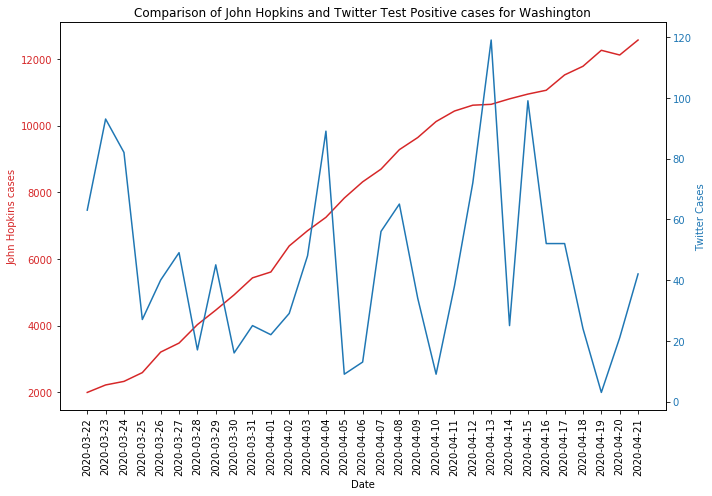

In [78]:


t = df_wa_grouped_merged['created_at_date']
data1 = df_wa_grouped_merged['cases_count_x']
data2 = df_wa_grouped_merged['cases_count_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins cases', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter Test Positive cases for Washington')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter Cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Indiana

In [79]:
df_jh_in = df_jh[df_jh['Province_State']=='Indiana']
df_jh_in = df_jh_in[['date', 'Province_State', 'Confirmed']]
df_jh_in= df_jh_in.groupby(['date', 'Province_State']).sum().reset_index()
df_jh_in.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_jh_in.head()

,created_at_date,cleaned_location_state,cases_count
0,2020-03-22,Indiana,204
1,2020-03-23,Indiana,270
2,2020-03-24,Indiana,368
3,2020-03-25,Indiana,477
4,2020-03-26,Indiana,645


In [80]:


df_in=df_processed[df_processed['cleaned_location_state']=='Indiana']
df_in=df_in[df_in['test_positive_y_n']==True]
df_in = df_in[['created_at_date', 'cleaned_location_state', 'test_positive_y_n']]
df_in_grouped = df_in.groupby(['created_at_date','cleaned_location_state']).count().reset_index()
df_in_grouped.columns=['created_at_date', 'cleaned_location_state', 'cases_count']
df_in_grouped.head()


,created_at_date,cleaned_location_state,cases_count
0,2020-03-21,Indiana,9
1,2020-03-22,Indiana,27
2,2020-03-23,Indiana,9
3,2020-03-24,Indiana,58
4,2020-03-25,Indiana,4


In [81]:
df_in_grouped_merged = df_jh_in.merge(df_in_grouped, on=['created_at_date', 'cleaned_location_state'])
df_in_grouped_merged.head()

,created_at_date,cleaned_location_state,cases_count_x,cases_count_y
0,2020-03-22,Indiana,204,27
1,2020-03-23,Indiana,270,9
2,2020-03-24,Indiana,368,58
3,2020-03-25,Indiana,477,4
4,2020-03-26,Indiana,645,9


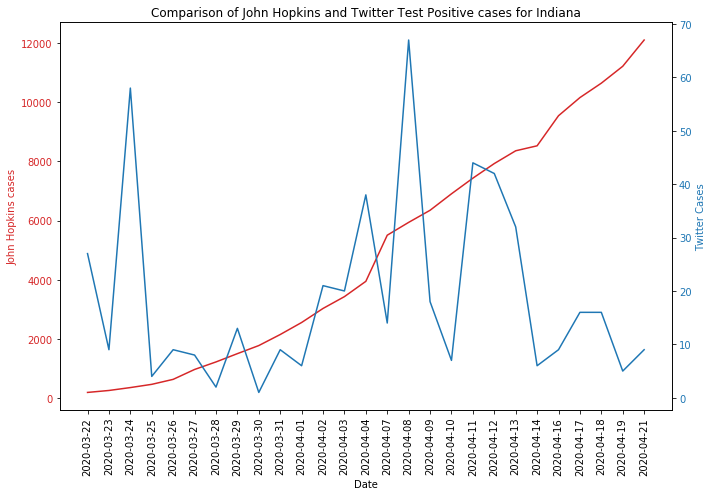

In [82]:


t = df_in_grouped_merged['created_at_date']
data1 = df_in_grouped_merged['cases_count_x']
data2 = df_in_grouped_merged['cases_count_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins cases', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter Test Positive cases for Indiana')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter Cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [83]:
df_jh.head()

,Unnamed: 0,Province_State,Country_Region,Last_Update,Confirmed,Deaths,date
304,304,New York,US,2020-03-22 23:45:00,9654,63,2020-03-22
305,305,New York,US,2020-03-22 23:45:00,1900,4,2020-03-22
306,306,New York,US,2020-03-22 23:45:00,1873,0,2020-03-22
307,307,New York,US,2020-03-22 23:45:00,1034,9,2020-03-22
308,308,New York,US,2020-03-22 23:45:00,455,1,2020-03-22


In [84]:
df.head()

,created_at,favourites_count,followers_count,friends_count,full_text,location,retweet_count,screen_name,statuses_count,tweet,...,cleaned_location_1,created_at_datetime,created_at_date,tokens_location,tokens_location_bigram,token_string,test_positive_y_n,cleaned_location_state,cleaned_location_country,death_y_n
0,2020-03-21 17:34:31,29842,62327,980,At the same time the president is in the brief...,🇺🇸🇺🇸🇺🇸,336,LizRNC,8476,Status(full_text=u'At the same time the presid...,...,,2020-03-21 17:34:31,2020-03-21,[blank],[],"time,presid,brief,room,talk,hope,drug,treat,wu...",True,Unknown,Unknown,False
1,2020-03-21 17:01:32,29842,62327,980,"This is really gross, but we shouldn't be surp...",🇺🇸🇺🇸🇺🇸,453,LizRNC,8476,"Status(full_text=u'This is really gross, but w...",...,,2020-03-21 17:01:32,2020-03-21,[blank],[],"realli,gross,shouldnt,surpriseddemocrat,push,c...",False,Unknown,Unknown,False
2,2020-03-21 03:11:06,69,12466,340,China hid information about the Wuhan Virus.\r...,"Green Cove Springs, FL",498,JudsonSapp,529,Status(full_text=u'China hid information about...,...,green cove springs,2020-03-21 03:11:06,2020-03-21,"[green, cove, spring, fl]","[(green, cove), (cove, spring), (spring, fl)]","china,inform,wuhan,china,allow,wuhan,spread,pr...",False,Florida,US,True
3,2020-03-21 21:25:49,231,187501,755,This Coronavirus is the first thing they’re no...,New York,370,MarkSimoneNY,21075,Status(full_text=u'This Coronavirus is the fir...,...,york,2020-03-21 21:25:49,2020-03-21,"[new, york]","[(new, york)]","coronaviru,first,thing,proud,stamp,made,china,...",True,New York,US,False
4,2020-03-21 01:02:45,29842,62327,980,"The people screaming about ""UKRAINE!"" througho...",🇺🇸🇺🇸🇺🇸,243,LizRNC,8476,Status(full_text=u'The people screaming about ...,...,,2020-03-21 01:02:45,2020-03-21,[blank],[],"peopl,scream,ukrain,throughout,tell,ahead,curv...",False,Unknown,Unknown,False


In [144]:
df_jh_de = df_jh[df_jh['Country_Region']=='US']
df_jh_de = df_jh[['date', 'Deaths']]
df_jh_de_grouped = df_jh_de.groupby('date').sum().reset_index()
df_jh_de_grouped.columns=['Date', 'Count of Deaths']
df_jh_de_grouped['Date'] = pd.to_datetime(df_jh_de_grouped['Date'])

In [145]:
df_jh_de_grouped.head()

,Date,Count of Deaths
0,2020-03-22,427
1,2020-03-23,552
2,2020-03-24,706
3,2020-03-25,942
4,2020-03-26,1209


In [153]:
df_de = df[df['cleaned_location_country']=='US']
df_de = df_de[['created_at_date', 'death_y_n']]
df_de = df_de[df_de['death_y_n']==True]
df_de_grouped = df_de.groupby('created_at_date').count().reset_index()
df_de_grouped.columns = ['Date', 'Count of Deaths']
df_de_grouped['Date'] = pd.to_datetime(df_de_grouped['Date'])

In [154]:
df_de_grouped.head()

,Date,Count of Deaths
0,2020-03-21,18
1,2020-03-22,28
2,2020-03-23,19
3,2020-03-24,34
4,2020-03-25,9


In [155]:
df_de_grouped_merged = df_jh_de_grouped.merge(df_de_grouped, on=['Date'])
df_de_grouped_merged.head()

,Date,Count of Deaths_x,Count of Deaths_y
0,2020-03-22,427,28
1,2020-03-23,552,19
2,2020-03-24,706,34
3,2020-03-25,942,9
4,2020-03-26,1209,8


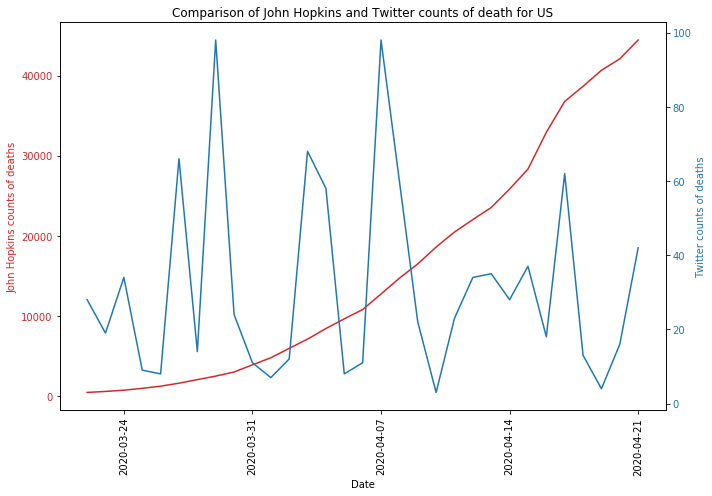

In [156]:


t = df_de_grouped_merged['Date']
data1 = df_de_grouped_merged['Count of Deaths_x']
data2 = df_de_grouped_merged['Count of Deaths_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins counts of deaths', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter counts of death for US')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter counts of deaths', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [158]:
df_jh_cases = df_jh[df_jh['Country_Region']=='US']
df_jh_cases = df_jh[['date', 'Confirmed']]
df_jh_cases_grouped = df_jh_cases.groupby('date').sum().reset_index()
df_jh_cases_grouped.columns=['Date', 'Count of Cases']
df_jh_cases_grouped['Date'] = pd.to_datetime(df_jh_cases_grouped['Date'])
df_jh_cases_grouped.head()

,Date,Count of Cases
0,2020-03-22,33848
1,2020-03-23,43663
2,2020-03-24,53736
3,2020-03-25,65778
4,2020-03-26,83836


In [159]:
df_cases = df[df['cleaned_location_country']=='US']
df_cases = df[['created_at_date', 'test_positive_y_n']]
df_cases = df_cases[df_cases['test_positive_y_n']==True]
df_cases_grouped = df_cases.groupby('created_at_date').count().reset_index()
df_cases_grouped.columns = ['Date', 'Count of Cases']
df_cases_grouped['Date'] = pd.to_datetime(df_cases_grouped['Date'])
df_cases_grouped.head()

,Date,Count of Cases
0,2020-03-21,200
1,2020-03-22,383
2,2020-03-23,333
3,2020-03-24,363
4,2020-03-25,156


In [160]:
df_cases_grouped_merged = df_jh_cases_grouped.merge(df_cases_grouped, on=['Date'])
df_cases_grouped_merged.head()

,Date,Count of Cases_x,Count of Cases_y
0,2020-03-22,33848,383
1,2020-03-23,43663,333
2,2020-03-24,53736,363
3,2020-03-25,65778,156
4,2020-03-26,83836,128


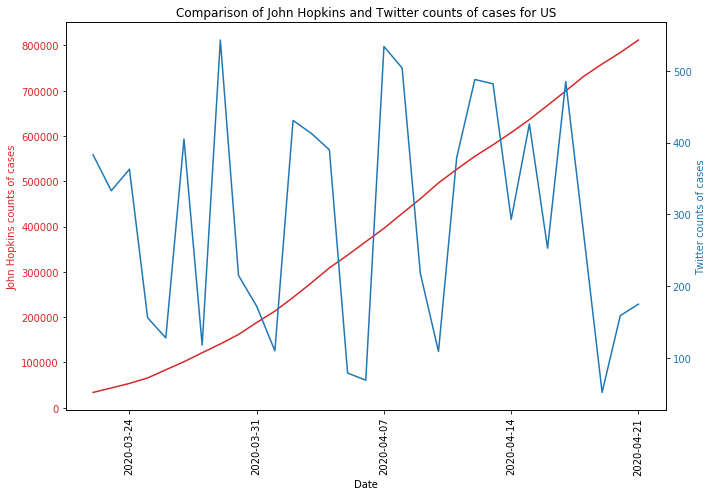

In [161]:


t = df_cases_grouped_merged['Date']
data1 = df_cases_grouped_merged['Count of Cases_x']
data2 = df_cases_grouped_merged['Count of Cases_y']

fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('John Hopkins counts of cases', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Comparison of John Hopkins and Twitter counts of cases for US')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Twitter counts of cases', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
